In [ ]:
# Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Fetching historical data for BTC/USD, ETH/USD, and DOT/USD
train_start_date = '2020-08-20' # Date when Polkadot was launched
train_end_date = '2023-07-01' # To leave a year for testing

# Individual coins
BTC_data = yf.download('BTC-USD', train_start_date, train_end_date) # Bitcoin
ETH_data = yf.download('ETH-USD', train_start_date, train_end_date) # Ethereum
DOT_data = yf.download('DOT-USD', train_start_date, train_end_date) # Polkadot

# Keeping only closing prices
BTC_data = BTC_data['Close']
ETH_data = ETH_data['Close']
DOT_data = DOT_data['Close']

# Combining into a single DataFrame
data = pd.DataFrame({
    'BTC/USD': BTC_data,
    'ETH/USD': ETH_data,
    'DOT/USD': DOT_data
})
print(f"\nNA count: \n{data.isna().sum()}\n")
print("Data Description:")
data.describe()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


NA count: 
BTC/USD    0
ETH/USD    0
DOT/USD    0
dtype: int64

Data Description:


,BTC/USD,ETH/USD,DOT/USD
count,1045.000000,1045.000000,1045.000000
mean,32751.245676,2022.096428,15.811351
std,14391.245531,1054.346042,12.410681
min,10131.516602,321.116302,2.875028
25%,20471.482422,1309.328735,5.885611
50%,29906.662109,1812.589478,9.208837
75%,43574.507812,2764.431152,23.852982
max,67566.828125,4812.087402,53.881733


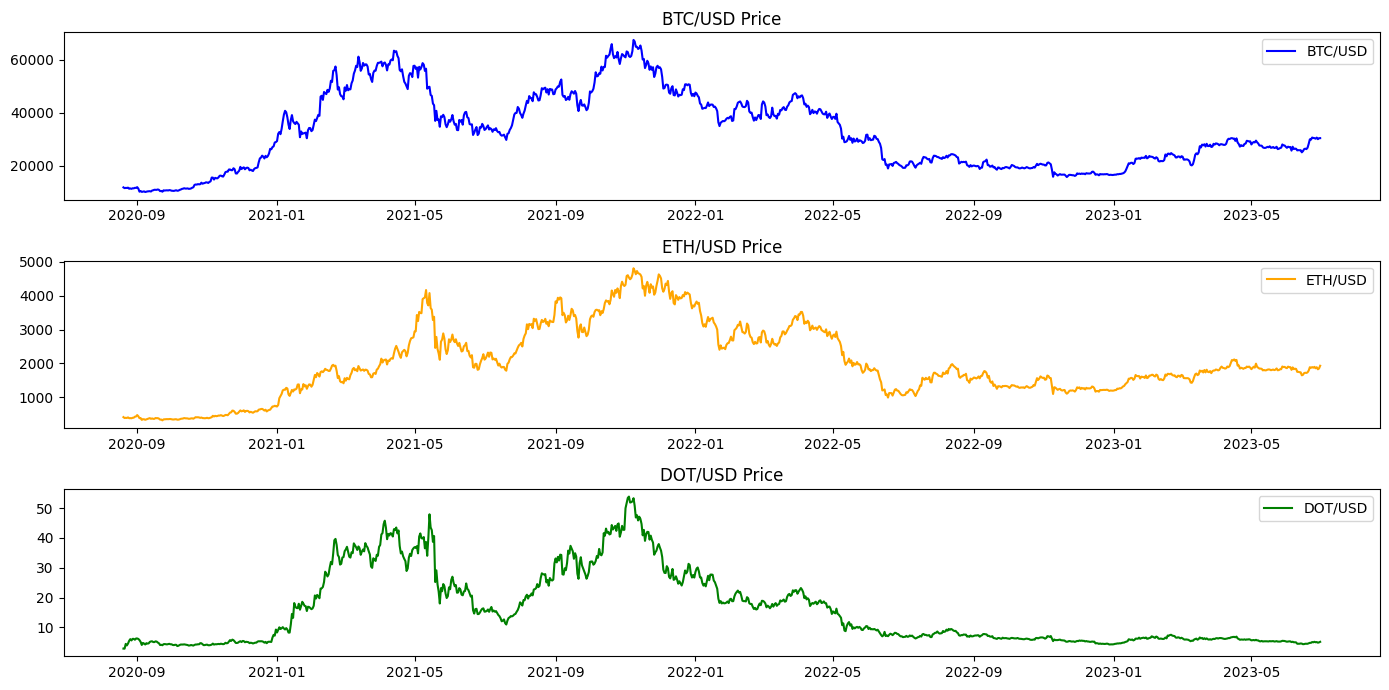

In [ ]:
# Plotting individual coins over time
plt.figure(figsize=(14, 7))
plt.subplot(3, 1, 1)
plt.plot(data['BTC/USD'], label='BTC/USD', color='blue')
plt.title('BTC/USD Price')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data['ETH/USD'], label='ETH/USD', color='orange')
plt.title('ETH/USD Price')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(data['DOT/USD'], label='DOT/USD', color='green')
plt.title('DOT/USD Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculating a general correlation matrix, to test the fitness of coin choises
correlation_matrix = data.corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
           BTC/USD   ETH/USD   DOT/USD
BTC/USD  1.000000  0.835214  0.940718
ETH/USD  0.835214  1.000000  0.777775
DOT/USD  0.940718  0.777775  1.000000


In [ ]:
def max_correlation_with_dot(correlation_matrix):
  """Checking which of Bitcoin and Etherium has the better correlation with the weak coin
  returns either the stronger or no coin, depending on both correlations."""
    #  Setting thresholds
    min_corr = 0.6
    strong_corr = 0.7

    # Retrieving BTC/DOT and ETH/DOT correlations
    correlations = correlation_matrix["DOT/USD"].drop("DOT/USD")
    BTC_corr = correlations[0]
    ETH_corr = correlations[1]

    if BTC_corr > min_corr and ETH_corr > min_corr:
      if BTC_corr > ETH_corr: return "BTC/USD"
      elif ETH_corr > BTC_corr: return "ETH/USD"
      else: return "BTC/USD"

    elif BTC_corr < 0 or ETH_corr < 0:
      return None

    elif BTC_corr > strong_corr: return "BTC/USD"
    elif ETH_corr > strong_corr: return "ETH/USD"

    else: return None


In [ ]:
def turtle_trading_signals(prices, long_period=25, short_period=10):
    """Generating appropriate signals for Turtle Trading"""
    # Calculating the highest high and lowest low over the given periods
    highest_high_long = prices.rolling(window=long_period).max()
    lowest_low_long = prices.rolling(window=long_period).min()
    highest_high_short = prices.rolling(window=short_period).max()
    lowest_low_short = prices.rolling(window=short_period).min()

    # Creating a DataFrame for signals
    signals = pd.DataFrame(index=prices.index)
    signals['Close'] = prices
    signals['Long'] = 0
    signals['Short'] = 0

    # Generating buy signals (enter long position)
    signals.loc[signals['Close'] >= highest_high_long.shift(1), 'Long'] = 1

    # Generating exit signals for long positions (exit from long position)
    signals.loc[signals['Close'] <= lowest_low_short.shift(1), 'Long'] = -1

    # Generating sell signals (enter short position)
    signals.loc[signals['Close'] <= lowest_low_long.shift(1), 'Short'] = 1

    # Generating exit signals for short positions (exit from short position)
    signals.loc[signals['Close'] >= highest_high_short.shift(1), 'Short'] = -1

    return signals

In [ ]:
def backtest_turtle_trading(signals, initial_cash=100000):
    """Backtest for a single coin Turtle Trading strategy"""
    # Setting trading variables
    cash = initial_cash
    position = 0  # Number of shares
    portfolio_value = []

    # Executing trading desicions
    for i in range(1, len(signals)):
        if signals['Long'].iloc[i] == 1 and position == 0:  # Enter long position
            position = cash / signals['Close'].iloc[i]
            cash -= position * signals['Close'].iloc[i]

        elif signals['Long'].iloc[i] == -1 and position > 0:  # Exit long position
            cash += position * signals['Close'].iloc[i]
            position = 0

        elif signals['Short'].iloc[i] == 1 and position == 0:  # Enter short position
            position = -cash / signals['Close'].iloc[i]
            cash += -position * signals['Close'].iloc[i]

        elif signals['Short'].iloc[i] == -1 and position < 0:  # Exit short position
            cash -= -position * signals['Close'].iloc[i]
            position = 0

        portfolio_value.append(cash + position * signals['Close'].iloc[i])

    return portfolio_value

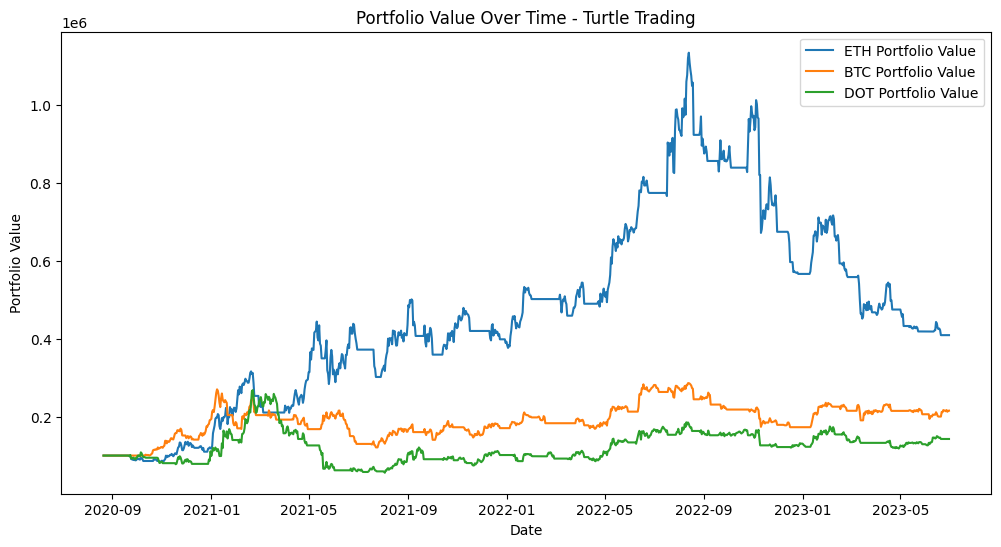

In [ ]:
# Executing strategies for each currency
ETH_signals = turtle_trading_signals(data['ETH/USD'])
ETH_portfolio_value = backtest_turtle_trading(ETH_signals)

BTC_signals = turtle_trading_signals(data['BTC/USD'])
BTC_portfolio_value = backtest_turtle_trading(BTC_signals)

DOT_signals = turtle_trading_signals(data['DOT/USD'])
DOT_portfolio_value = backtest_turtle_trading(DOT_signals)


# Plotting the portfolio values over time
plt.figure(figsize=(12, 6))
plt.plot(ETH_signals.index[1:], ETH_portfolio_value, label="ETH Portfolio Value")
plt.plot(BTC_signals.index[1:], BTC_portfolio_value, label="BTC Portfolio Value")
plt.plot(DOT_signals.index[1:], DOT_portfolio_value, label="DOT Portfolio Value")
plt.title("Portfolio Value Over Time - Turtle Trading")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

In [ ]:
def backtest(ETH, BTC, DOT, initial_cash=100000,correlation_matrix=correlation_matrix,data=data):
    """ Executing strategy """
    # Setting trading variables
    cash = initial_cash
    position = 0  # Number of shares
    portfolio_value = []

    # Executing trading desicions
    for i in range(1, len(data)):
        # Testing correlations
        correlation_matrix = data[i-30:i].corr()

        strong_coin = None
        max_corr_coin = max_correlation_with_dot(correlation_matrix)

        if max_corr_coin is None:
            strong_coin = None
        elif max_corr_coin == 'ETH/USD':
            strong_coin = ETH
        else:
            strong_coin = BTC

        # Executing strategy for the appropriate situation
        if strong_coin is None and position > 0:
            cash += position * DOT['Close'].iloc[i]
            position = 0

        elif strong_coin is None and position < 0:
            cash -= -position * DOT['Close'].iloc[i]
            position = 0

        elif strong_coin is None:
            portfolio_value.append(cash + position * DOT['Close'].iloc[i])
            continue

        elif DOT['Long'].iloc[i] == 1 and strong_coin['Long'].iloc[i] == 1 and position == 0:  # Enter long position
            position = cash / DOT['Close'].iloc[i]
            cash -= position * DOT['Close'].iloc[i]

        elif DOT['Long'].iloc[i] == -1 and strong_coin['Long'].iloc[i] == -1 and position > 0:  # Exit long position
            cash += position * DOT['Close'].iloc[i]
            position = 0

        elif DOT['Short'].iloc[i] == 1 and strong_coin['Short'].iloc[i] == 1 and position == 0:  # Enter short position
            position = -cash / DOT['Close'].iloc[i]
            cash += -position * DOT['Close'].iloc[i]

        elif DOT['Short'].iloc[i] == -1 and strong_coin['Short'].iloc[i] == -1 and position < 0:  # Exit short position
            cash -= -position * DOT['Close'].iloc[i]
            position = 0

        portfolio_value.append(cash + position * DOT['Close'].iloc[i])

    return portfolio_value

In [ ]:
# Backtesting
ETH_signals = turtle_trading_signals(data['ETH/USD'])
BTC_signals = turtle_trading_signals(data['BTC/USD'])
DOT_signals = turtle_trading_signals(data['DOT/USD'])
portfolio_value = backtest(ETH_signals, BTC_signals, DOT_signals)

In [ ]:
# Setting a Buy & Hold strategy for comparison
initial_investment = 100000
initial_price = DOT_data[0]
shares = initial_investment / initial_price
buy_and_hold_value = DOT_data * shares

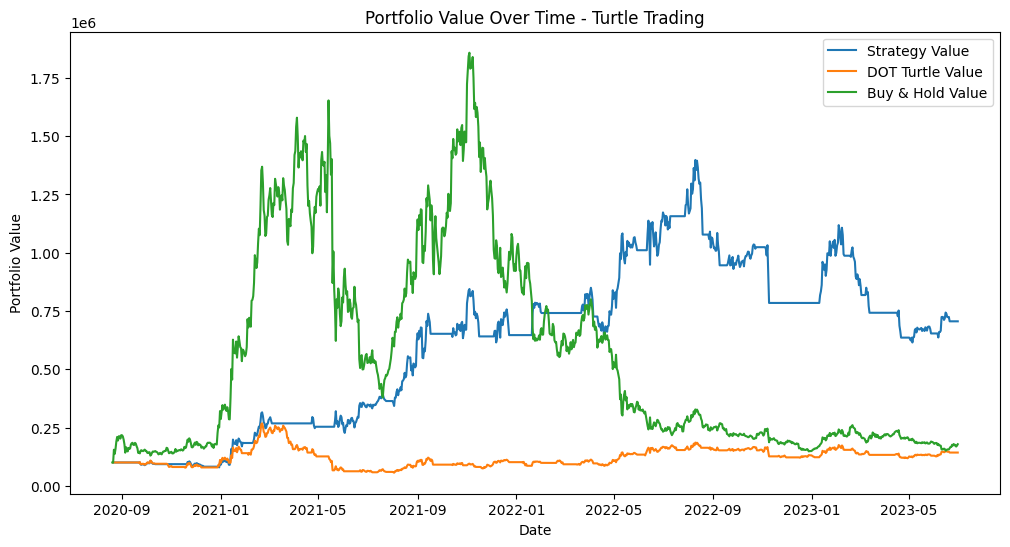

In [ ]:
# Plotting portfolio values for each strategy
plt.figure(figsize=(12, 6))
plt.plot(DOT_signals.index[1:], portfolio_value, label="Strategy Value")
plt.plot(DOT_signals.index[1:], DOT_portfolio_value, label="DOT Turtle Value")
plt.plot(DOT_data.index, buy_and_hold_value, label="Buy & Hold Value")

plt.title("Portfolio Value Over Time - Turtle Trading")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

In [ ]:
# Comparing results
buy_and_hold_value = buy_and_hold_value[-1]
dot_turtle_value = DOT_portfolio_value[-1]
strategy_value = portfolio_value[-1]
buy_and_hold_percent = (buy_and_hold_value / 100000 - 1) * 100
dot_turtle_percent = (dot_turtle_value / 100000 - 1) * 100
strategy_percent = (strategy_value / 100000 - 1) * 100

print(f"Buy & Hold: {buy_and_hold_value} {buy_and_hold_percent:.2f}% \nDOT Turtle: {dot_turtle_value} {dot_turtle_percent:.2f}% \nStrategy: {strategy_value} {strategy_percent:.2f}%")

if strategy_value >= dot_turtle_value and strategy_value >= buy_and_hold_value:
  print("Strategy WIN")
else:
  print("Strategy LOSE")

Buy & Hold: 178329.66411776832 78.33% 
DOT Turtle: 142575.15209063172 42.58% 
Strategy: 705607.9861821095 605.61%
Strategy WIN


In [ ]:
yearly_trading_days = 365 # Could variate for other types or investments
portfolio_value = pd.Series(portfolio_value)

def calc_total_return(portfolio_values):
    return (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1.0

def calc_annualized_return(portfolio_values):
    portfolio_trading_days = len(portfolio_values)
    portfolio_trading_years = portfolio_trading_days / 365
    return (portfolio_values.iloc[-1] / portfolio_values.iloc[0])**(1/portfolio_trading_years) - 1.0

def calc_annualized_sharpe(portfolio_values: pd.Series, rf: float=0.0):
    annualized_return = calc_annualized_return(portfolio_values)
    annualized_std = portfolio_values.pct_change().std() * np.sqrt(yearly_trading_days)
    if annualized_std is None or annualized_std == 0:
        return 0
    sharpe = (annualized_return - rf) / annualized_std
    return sharpe

def calc_downside_deviation(portfolio_values):
    porfolio_returns = portfolio_values.pct_change().dropna()
    return porfolio_returns[porfolio_returns < 0].std()

def calc_sortino(portfolio_values, rf=0.0):
    down_deviation = calc_downside_deviation(portfolio_values) * np.sqrt(yearly_trading_days)
    annualized_return = calc_annualized_return(portfolio_values)
    if down_deviation is None or down_deviation == 0:
        return 0
    sortino = (annualized_return - rf) / down_deviation
    return sortino

def calc_max_drawdown(portfolio_values):
    cumulative_max = portfolio_values.cummax()
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    return drawdown.max()

def calc_calmar(portfolio_values):
    max_drawdown = calc_max_drawdown(portfolio_values)
    annualized_return = calc_annualized_return(portfolio_values)
    return annualized_return / max_drawdown

def evaluate_strategy(portfolio_value):
  """Using the functions above, we are checking the results of this strategy for risk, return and known ratios."""
    total_return = calc_total_return(portfolio_value)
    annualized_return = calc_annualized_return(portfolio_value)
    annualized_sharpe = calc_annualized_sharpe(portfolio_value)
    sortino_ratio = calc_sortino(portfolio_value)
    max_drawdown = calc_max_drawdown(portfolio_value)
    calmar_ratio = calc_calmar(portfolio_value)

    # Print the evaluation results
    print(f"Results for the strategy:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")

evaluate_strategy(portfolio_value)

Results for the strategy:
Total Return: 605.61%
Annualized Return: 98.00%
Annualized Sharpe Ratio: 1.23
Sortino Ratio: 1.68
Max Drawdown: 56.02%
Calmar Ratio: 1.75


-------------------------------------------------------------------------------------------------------------- Test --------------------------------------------------------------------------------------------------------------
Executing the same functions for the test periods

In [ ]:
test_start_date = '2023-07-01'
test_end_date = '2024-07-01'
test_BTC_data = yf.download('BTC-USD', test_start_date, test_end_date) # Bitcoin
test_ETH_data = yf.download('ETH-USD', test_start_date, test_end_date) # Ethereum
test_DOT_data = yf.download('DOT-USD', test_start_date, test_end_date) # Polkadot

test_BTC_data = test_BTC_data['Close']
test_ETH_data = test_ETH_data['Close']
test_DOT_data = test_DOT_data['Close']

test_data = pd.DataFrame({
    'BTC/USD': test_BTC_data,
    'ETH/USD': test_ETH_data,
    'DOT/USD': test_DOT_data
})

print(f"\nNA count: \n{test_data.isna().sum()}\n")
test_data.describe()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



NA count: 
BTC/USD    0
ETH/USD    0
DOT/USD    0
dtype: int64



,BTC/USD,ETH/USD,DOT/USD
count,366.000000,366.000000,366.000000
mean,45836.198130,2501.957014,6.338914
std,16051.915087,755.035994,1.752203
min,25162.654297,1539.612427,3.648878
25%,29869.607910,1849.167938,4.990768
50%,42625.697266,2282.007812,6.420108
75%,63694.678711,3195.987488,7.358716
max,73083.500000,4066.445068,11.542902


In [ ]:
test_ETH_signals = turtle_trading_signals(test_data['ETH/USD'])
test_BTC_signals = turtle_trading_signals(test_data['BTC/USD'])
test_DOT_signals = turtle_trading_signals(test_data['DOT/USD'])
test_portfolio_value = backtest(test_ETH_signals, test_BTC_signals, test_DOT_signals,correlation_matrix = test_data.corr(),data=test_data)

In [ ]:
initial_investment = 100000
test_initial_price = test_DOT_data[0]
shares = initial_investment / test_initial_price
test_buy_and_hold_value = test_DOT_data * shares

test_DOT_signals = turtle_trading_signals(test_data['DOT/USD'])
test_DOT_portfolio_value = backtest_turtle_trading(test_DOT_signals)

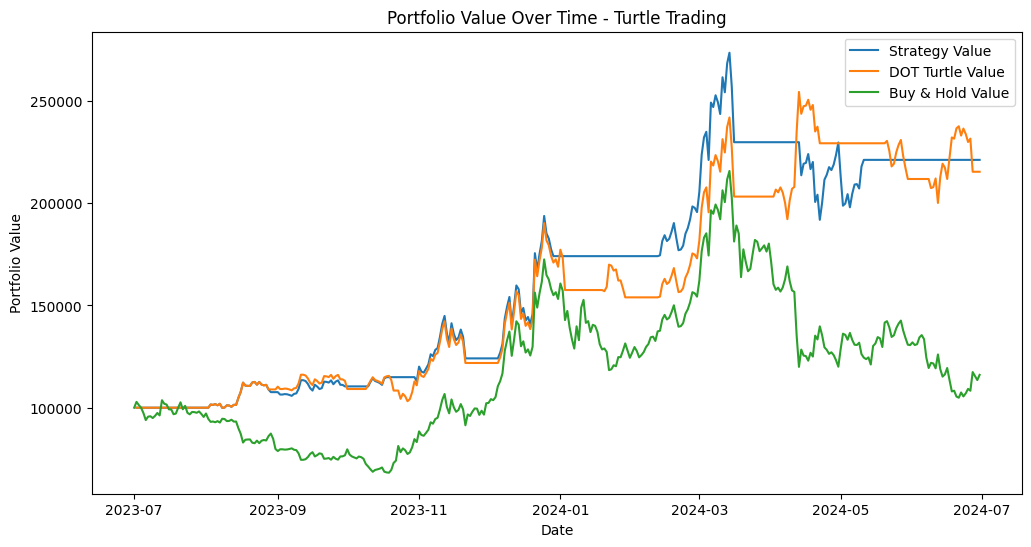

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_DOT_signals.index[1:], test_portfolio_value, label="Strategy Value")
plt.plot(test_DOT_signals.index[1:], test_DOT_portfolio_value, label="DOT Turtle Value")
plt.plot(test_DOT_data.index, test_buy_and_hold_value, label="Buy & Hold Value")

plt.title("Portfolio Value Over Time - Turtle Trading")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

In [ ]:
test_buy_and_hold_value = test_buy_and_hold_value[-1]
test_dot_turtle_value = test_DOT_portfolio_value[-1]
test_strategy_value = test_portfolio_value[-1]
test_buy_and_hold_percent = (test_buy_and_hold_value / 100000 - 1) * 100
test_dot_turtle_percent = (test_dot_turtle_value / 100000 - 1) * 100
test_strategy_percent = (test_strategy_value / 100000 - 1) * 100

print(f"Buy & Hold: {test_buy_and_hold_value} {test_buy_and_hold_percent:.2f}% \nDOT Turtle: {test_dot_turtle_value} {test_dot_turtle_percent:.2f}% \nStrategy: {test_strategy_value} {test_strategy_percent:.2f}%")

if test_strategy_value >= test_dot_turtle_value and test_strategy_value >= test_buy_and_hold_value:
  print("Strategy WIN")
else:
  print("Strategy LOSE")

Buy & Hold: 116053.5751419014 16.05% 
DOT Turtle: 215368.69851161138 115.37% 
Strategy: 221177.56737289656 121.18%
Strategy WIN


In [ ]:
test_portfolio_value = pd.Series(test_portfolio_value)
evaluate_strategy(test_portfolio_value)

Results for the strategy:
Total Return: 121.18%
Annualized Return: 121.18%
Annualized Sharpe Ratio: 2.44
Sortino Ratio: 2.53
Max Drawdown: 29.87%
Calmar Ratio: 4.06
